In [1]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, Subset, random_split
import torchvision.transforms as transforms
# from torchvision.datasets import MNIST
from torchvision import datasets
from torchvision.utils import make_grid
import torchshow as ts

import numpy as np
import functools

import tqdm
from pathlib import Path
import os

from scipy import integrate
from torch.utils.tensorboard import SummaryWriter
import time
from pathlib import Path
import math
from collections import defaultdict

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:

#@title Set up the SDE
def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  # t = torch.tensor(t, device=device, dtype=torch.float32) # KHJ : : To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # t = torch.tensor(t.clone().detach().requires_grad_(True), device=device, dtype=torch.float32)
  _t = t.clone().detach()
  return torch.sqrt((sigma**(2 * _t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  # return torch.tensor(sigma**t, device=device, dtype=torch.float32) # KHJ : To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _t = t.clone().detach()
  # return torch.tensor(sigma** _t, device=device, dtype=torch.float32)
  return sigma** _t

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [4]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [5]:

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, in_channel = 1, num_labels=None):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(in_channel, channels[0], 3, stride=1, padding = 1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding = 1, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding = 1, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding = 1, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, padding=1, output_padding=1)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, padding=1, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, padding=1, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], in_channel, 3, stride=1, padding=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

    if num_labels is not None:
      self.label_emb = nn.Embedding(num_labels, embed_dim)

  def forward(self, x, t, labels=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    if labels is not None:
      embed += self.label_emb(labels)
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [6]:
## Unet network model
# Ref: https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/Denoising_Diffusion_Probabilistic_Models/unet.py

def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    Retrieved from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py#LL90C1-L109C13
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.type(torch.float32)[:, None] * emb[None, :]
    emb = torch.concat([torch.sin(emb), torch.cos(emb)], axis=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))

    assert emb.shape == (timesteps.shape[0], embedding_dim), f"{emb.shape}"
    return emb


class Downsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=2, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)
        assert x.shape == (B, C, H // 2, W // 2)
        return x


class Upsample(nn.Module):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=1, padding=1)

    def forward(self, x):
        B, C, H, W = x.shape

        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='nearest')

        x = self.conv(x)
        assert x.shape == (B, C, H * 2, W * 2)
        return x


class Nin(nn.Module):

    def __init__(self, in_dim, out_dim, scale=1e-10):
        super(Nin, self).__init__()

        n = (in_dim + out_dim) / 2
        limit = np.sqrt(3 * scale / n)
        self.W = torch.nn.Parameter(torch.zeros((in_dim, out_dim), dtype=torch.float32
                                                ).uniform_(-limit, limit))
        self.b = torch.nn.Parameter(torch.zeros((1, out_dim, 1, 1), dtype=torch.float32))

    def forward(self, x):
        return torch.einsum('bchw, co->bohw', x, self.W) + self.b


class ResNetBlock(nn.Module):

    def __init__(self, in_ch, out_ch, dropout_rate=0.1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.dense = nn.Linear(512, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1)

        if not (in_ch == out_ch):
            self.nin = Nin(in_ch, out_ch)

        self.dropout_rate = dropout_rate
        self.nonlinearity = torch.nn.SiLU()

    def forward(self, x, temb):
        """
        :param x: (B, C, H, W)
        :param temb: (B, dim)
        """

        h = self.nonlinearity(nn.functional.group_norm(x, num_groups=32))
        h = self.conv1(h)

        # add in timestep embedding
        h += self.dense(self.nonlinearity(temb))[:, :, None, None]

        h = self.nonlinearity(nn.functional.group_norm(h, num_groups=32))
        h = nn.functional.dropout(h, p=self.dropout_rate)
        h = self.conv2(h)

        if not (x.shape[1] == h.shape[1]):
            x = self.nin(x)

        assert x.shape == h.shape
        return x + h


class AttentionBlock(nn.Module):

    def __init__(self, ch):
        super(AttentionBlock, self).__init__()

        self.Q = Nin(ch, ch)
        self.K = Nin(ch, ch)
        self.V = Nin(ch, ch)

        self.ch = ch

        self.nin = Nin(ch, ch, scale=0.)

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == self.ch

        h = nn.functional.group_norm(x, num_groups=32)
        q = self.Q(h)
        k = self.K(h)
        v = self.V(h)

        w = torch.einsum('bchw,bcHW->bhwHW', q, k) * (int(C) ** (-0.5))  # [B, H, W, H, W]
        w = torch.reshape(w, [B, H, W, H * W])
        w = torch.nn.functional.softmax(w, dim=-1)
        w = torch.reshape(w, [B, H, W, H, W])

        h = torch.einsum('bhwHW,bcHW->bchw', w, v)
        h = self.nin(h)

        assert h.shape == x.shape
        return x + h


class UNet(nn.Module):

    def __init__(self, marginal_prob_std = None, ch=128, in_channel=1, label_dim=None):
        super(UNet, self).__init__()

        self.marginal_prob_std = marginal_prob_std
        self.ch = ch
        self.linear1 = nn.Linear(ch, 4 * ch)
        self.linear2 = nn.Linear(4 * ch, 4 * ch)

        self.conv1 = nn.Conv2d(in_channel, ch, 3, stride=1, padding=1)

        self.down = nn.ModuleList([ResNetBlock(ch, 1 * ch),
                                   ResNetBlock(1 * ch, 1 * ch),
                                   Downsample(1 * ch),
                                   ResNetBlock(1 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch)])

        self.middle = nn.ModuleList([ResNetBlock(2 * ch, 2 * ch),
                                     AttentionBlock(2 * ch),
                                     ResNetBlock(2 * ch, 2 * ch)])

        self.up = nn.ModuleList([ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(3 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(3 * ch, ch),
                                 ResNetBlock(2 * ch, ch),
                                 ResNetBlock(2 * ch, ch)])

        self.final_conv = nn.Conv2d(ch, in_channel, 3, stride=1, padding=1)

        if label_dim is not None:
            self.label_emb = nn.Linear(label_dim, self.ch * 4)

    def forward(self, x, t, labels=None):
        """
        :param x: (torch.Tensor) batch of images [B, C, H, W]
        :param t: (torch.Tensor) tensor of time steps (torch.long) [B]
        """

        temb = get_timestep_embedding(t, self.ch)
        temb = torch.nn.functional.silu(self.linear1(temb))
        temb = self.linear2(temb)
        assert temb.shape == (t.shape[0], self.ch * 4)
        if labels is not None:
            temb += self.label_emb(labels)

        x1 = self.conv1(x)

        # Down
        x2 = self.down[0](x1, temb)
        x3 = self.down[1](x2, temb)
        x4 = self.down[2](x3)
        x5 = self.down[3](x4, temb)
        x6 = self.down[4](x5)  # Attention
        x7 = self.down[5](x6, temb)
        x8 = self.down[6](x7)  # Attention
        x9 = self.down[7](x8)
        x10 = self.down[8](x9, temb)
        x11 = self.down[9](x10, temb)
        x12 = self.down[10](x11)
        x13 = self.down[11](x12, temb)
        x14 = self.down[12](x13, temb)

        # Middle
        x = self.middle[0](x14, temb)
        x = self.middle[1](x)
        x = self.middle[2](x, temb)

        # Up
        x = self.up[0](torch.cat((x, x14), dim=1), temb)
        x = self.up[1](torch.cat((x, x13), dim=1), temb)
        x = self.up[2](torch.cat((x, x12), dim=1), temb)
        x = self.up[3](x)
        x = self.up[4](torch.cat((x, x11), dim=1), temb)
        x = self.up[5](torch.cat((x, x10), dim=1), temb)
        x = self.up[6](torch.cat((x, x9), dim=1), temb)
        x = self.up[7](x)
        x = self.up[8](torch.cat((x, x8), dim=1), temb)
        x = self.up[9](x)
        x = self.up[10](torch.cat((x, x6), dim=1), temb)
        x = self.up[11](x)
        x = self.up[12](torch.cat((x, x4), dim=1), temb)
        x = self.up[13](x)
        x = self.up[14](x)
        x = self.up[15](torch.cat((x, x3), dim=1), temb)
        x = self.up[16](torch.cat((x, x2), dim=1), temb)
        x = self.up[17](torch.cat((x, x1), dim=1), temb)

        x = nn.functional.silu(nn.functional.group_norm(x, num_groups=32))
        x = self.final_conv(x)
        if self.marginal_prob_std is not None:
            x = x / self.marginal_prob_std(t)[:, None, None, None]
        return x



in_ch = 1
score_model = UNet(marginal_prob_std=marginal_prob_std_fn, in_channel=in_ch, label_dim=40)
x = torch.rand((1, in_ch, 64, 64), dtype=torch.float32)
t = torch.rand((1), dtype=torch.float32)
# l = torch.tensor([1])
l = torch.ones((1, 40), dtype=torch.float32)

print(x.shape)
print(t.shape)
print(l.shape)


y = score_model(x, t, l)


print(y.shape)


torch.Size([1, 1, 64, 64])
torch.Size([1])
torch.Size([1, 40])
torch.Size([1, 1, 64, 64])


In [7]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           img_shape = (1, 32, 32),
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3,
                           labels = None,
                           gamma = 3.0):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  if labels is not None:
     batch_size = min(batch_size, len(labels))
     labels = labels[:batch_size]
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn((batch_size,) + img_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    # for time_step in tqdm.tqdm(time_steps):
    for time_step in time_steps:
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)

      score_model.eval()
      with torch.no_grad():
          score = score_model(x, batch_time_step, labels)
          score_uncond = score_model(x, batch_time_step)
          score = score_uncond + gamma * (score - score_uncond)
      score_model.train()

      mean_x = x + (g**2)[:, None, None, None] * score * step_size
      # mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

In [8]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               img_shape = (1, 32, 32),
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-3,
               labels = None,
               gamma = 3.0):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  if labels is not None:
     batch_size = min(batch_size, len(labels))
     labels = labels[:batch_size]
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn((batch_size,) + img_shape, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    # for time_step in tqdm.tqdm(time_steps):
    for time_step in time_steps:
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)

      # grad = score_model(x, batch_time_step)
      score_model.eval()
      with torch.no_grad():
          score = score_model(x, batch_time_step, labels)
          score_uncond = score_model(x, batch_time_step)
          score = score_uncond + gamma * (score - score_uncond)
      score_model.train()
      grad = score

      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)

      score_model.eval()
      with torch.no_grad():
          score = score_model(x, batch_time_step, labels)
          score_uncond = score_model(x, batch_time_step)
          score = score_uncond + gamma * (score - score_uncond)
      score_model.train()
      x_mean = x + (g**2)[:, None, None, None] * score * step_size
      # x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean

In [9]:
#@title Define the ODE sampler (double click to expand or collapse)

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                img_shape = (1, 32, 32),
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3,
                labels = None,
                gamma = 3.0):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  if labels is not None:
     batch_size = min(batch_size, len(labels))
     labels = labels[:batch_size]
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn((batch_size,) + img_shape, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    # with torch.no_grad():
    #   score = score_model(sample, time_steps)
    score_model.eval()
    with torch.no_grad():
        score = score_model(sample, time_steps, labels)
        score_uncond = score_model(sample, time_steps)
        score = score_uncond + gamma * (score - score_uncond)
    score_model.train()
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t, dtype=torch.float32)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  # print(f"ODE_Sampler :: Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device, dtype=torch.float32 ).reshape(shape)

  return x

In [10]:
#@title Training (double click to expand or collapse)

g_model_path = './temp/models/Score_based_Models_Pytorch_CelebA_20_Conditional_Data_0_1/'
g_video_path = './temp/videos/Score_based_Models_Pytorch_CelebA_20_Conditional_Data_0_1/'
g_log_path = './temp/logs/Score_based_Models_Pytorch_CelebA_20_Conditional_Data_0_1/'
Path(g_model_path).mkdir(exist_ok=True, parents=True)
Path(g_video_path).mkdir(exist_ok=True, parents=True)
g_writer = SummaryWriter(g_log_path)

n_epochs =  16001 #@param {'type':'integer'}
## size of a mini-batch
batch_size =  4 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}
sample_batch_size = 4
nsample = batch_size * 5
eval_steps = 100


transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((128, 128),interpolation=transforms.InterpolationMode.BILINEAR, antialias=True),
                # transforms.Normalize(mean=(0.5), std=(0.5)) # Normalizes to [-1, 1]
            ])
dataset = datasets.CelebA(root='../temp_data/data', split='train', download=True, transform = transform)
in_ch = dataset[0][0].shape[0]
img_shape = tuple(dataset[0][0].shape)
label_dim = dataset[0][1].shape[0]

###############
# label_set = defaultdict(list)
# image_set = defaultdict(list)
# img_lst = []
# y_lst = []
# for i, d in enumerate(dataset):
#     # label_set.add(d[1])
#     if len(label_set[d[1]]) < batch_size:
#         label_set[d[1]].append(i)
#         image_set[d[1]].append(d[0])

# print(label_set)

# print(f"Size of dataset: {len(label_set)}")
# print(f"Label Set : {label_set}")

# # label_list = list(label_set.values())
# label_list = []
# for l in label_set.values():
#     label_list += l

# num_labels = len(label_set)
# print("------")
# print(label_list)
# label_list.sort()
# print(label_list)
# print(num_labels)


In [11]:
indices = list(range(nsample))
subset_dataset = Subset(dataset, indices)
data_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


score_model = UNet(marginal_prob_std=marginal_prob_std_fn, in_channel=in_ch, label_dim=label_dim)
score_model = score_model.to(device)
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.trange(n_epochs)
best_avg_loss = float('inf')
best_cnt = 0
test_label = None

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)
    y = y.to(device).to(torch.float32)
    if test_label is None:
      test_label = y.clone()
      test_label.to(device)
    if np.random.random() < 0.1:
      y = None
    loss = loss_fn(score_model, x, y, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]

  g_writer.add_scalar("Loss/AVG", avg_loss, epoch)
  if epoch % eval_steps == 0 or epoch == n_epochs - 1:
    # Test image
    
    # samples = ode_sampler(score_model,
    #                       marginal_prob_std_fn,
    #                       diffusion_coeff_fn,
    #                       batch_size = sample_batch_size,
    #                       img_shape=img_shape,
    #                       device=device,
    #                       labels=test_label)

    # img_op = os.path.join(g_video_path, f"ode_sampler_{epoch:03d}.jpg")
    # # samples = (samples.to("cpu") + 1) * 0.5
    # samples.clamp(0, 1.0)
    # ts.save(samples, img_op, ncols = 2)
    # img_grid = make_grid(samples)
    # g_writer.add_image('Image/ode_sampler', img_grid, global_step=epoch)

    samples = pc_sampler(score_model,
                        marginal_prob_std_fn,
                        diffusion_coeff_fn,
                        sample_batch_size,
                        img_shape=img_shape,
                        device=device,
                        labels=test_label)

    img_op = os.path.join(g_video_path, f"pc_sampler{epoch:03d}.jpg")
    # samples = (samples.to("cpu") + 1) * 0.5
    samples.clamp(0, 1.0)
    ts.save(samples, img_op, ncols = 2)
    img_grid = make_grid(samples)
    g_writer.add_image('Image/pc_sampler', img_grid, global_step=epoch)


    samples = Euler_Maruyama_sampler(score_model,
                                    marginal_prob_std_fn,
                                    diffusion_coeff_fn,
                                    sample_batch_size,
                                    img_shape=img_shape,
                                    device=device,
                                    labels=test_label)

    img_op = os.path.join(g_video_path, f"Euler_Maruyama_sampler_{epoch:03d}.jpg")
    # samples = (samples.to("cpu") + 1) * 0.5
    samples.clamp(0, 1.0)
    ts.save(samples, img_op, ncols = 2)
    img_grid = make_grid(samples)
    g_writer.add_image('Image/Euler_Maruyama_sampler', img_grid, global_step=epoch)

  if avg_loss < best_avg_loss:
    best_cnt += 1
    if best_cnt % 100 == 0:
      best_cnt = 0
      print(f"Best Loss : {avg_loss:.5f}")

    best_avg_loss = avg_loss
    model_path = os.path.join(g_model_path, 'ckpt_best.pth')
    torch.save(score_model.state_dict(), model_path)

  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  model_path = os.path.join(g_model_path, 'ckpt_last.pth')
  torch.save(score_model.state_dict(), model_path)

Average Loss: 98.621982: 100%|██████████| 16001/16001 [25:42:15<00:00,  5.78s/it]      


In [12]:
label_dim

40

In [13]:
samples = ode_sampler(score_model,
                      marginal_prob_std_fn,
                      diffusion_coeff_fn,
                      batch_size = sample_batch_size,
                      img_shape=img_shape,
                      device=device,
                      labels=test_label)

img_op = os.path.join(g_video_path, f"ode_sampler_{epoch:03d}.jpg")
# samples = (samples.to("cpu") + 1) * 0.5
samples.clamp(0, 1.0)
ts.save(samples, img_op, ncols = 2)
img_grid = make_grid(samples)
g_writer.add_image('Image/ode_sampler', img_grid, global_step=epoch)

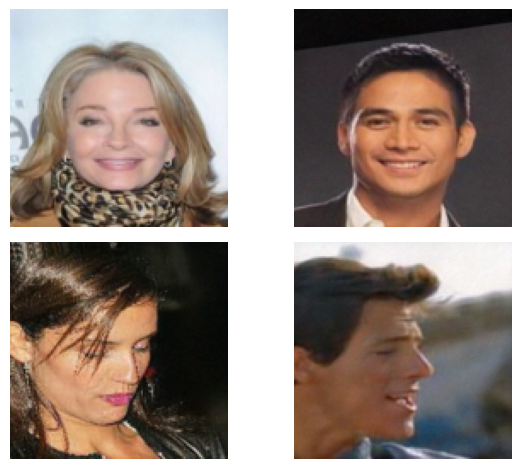

In [14]:
samples = pc_sampler(score_model,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    sample_batch_size,
                    img_shape=img_shape,
                    device=device,
                    labels=test_label, 
                    gamma=1)
ts.show(samples)

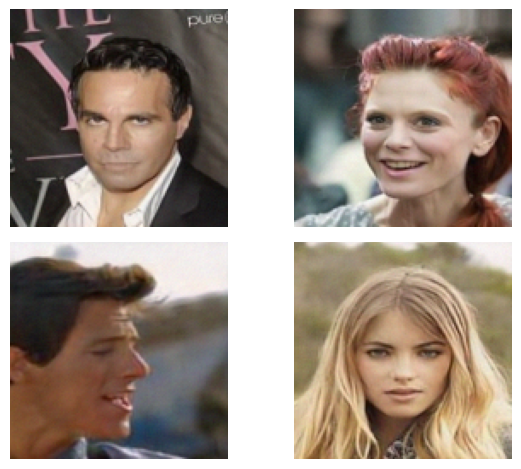

In [15]:
samples = pc_sampler(score_model,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    sample_batch_size,
                    img_shape=img_shape,
                    device=device,
                    labels=test_label, 
                    gamma=0)
ts.show(samples)

In [22]:
for i in range(50,501, 50):

    print(f"num_steps = {i}")
    samples = Euler_Maruyama_sampler(score_model,
                                    marginal_prob_std_fn,
                                    diffusion_coeff_fn,
                                    sample_batch_size,
                                    img_shape=img_shape,
                                    device=device,
                                    labels=test_label,
                                    num_steps=i,
                                    gamma=3)
    # ts.show(samples)
    img_op = os.path.join(g_video_path, f"Euler_Maruyama_sampler_num_steps_{i:05d}.jpg")
    # samples = (samples.to("cpu") + 1) * 0.5
    samples.clamp(0, 1.0)
    ts.save(samples, img_op, ncols = 2)


num_steps = 50
num_steps = 100
num_steps = 150
num_steps = 200
num_steps = 250
num_steps = 300
num_steps = 350
num_steps = 400
num_steps = 450
num_steps = 500


In [23]:
for i in range(10):

    print(f"gamma = {i}")
    samples = Euler_Maruyama_sampler(score_model,
                                    marginal_prob_std_fn,
                                    diffusion_coeff_fn,
                                    sample_batch_size,
                                    img_shape=img_shape,
                                    device=device,
                                    labels=test_label,
                                    # num_steps=500,
                                    gamma=i)
    # ts.show(samples)
    img_op = os.path.join(g_video_path, f"Euler_Maruyama_sampler_gamma_{i:05d}.jpg")
    # samples = (samples.to("cpu") + 1) * 0.5
    samples.clamp(0, 1.0)
    ts.save(samples, img_op, ncols = 2)

gamma = 0
gamma = 1
gamma = 2
gamma = 3
gamma = 4
gamma = 5
gamma = 6
gamma = 7
gamma = 8
gamma = 9


In [24]:
for i in range(50,501, 50):

    print(f"num_steps = {i}")
    samples = pc_sampler(score_model,
                                    marginal_prob_std_fn,
                                    diffusion_coeff_fn,
                                    sample_batch_size,
                                    img_shape=img_shape,
                                    device=device,
                                    labels=test_label,
                                    num_steps=i,
                                    gamma=3)
    # ts.show(samples)
    img_op = os.path.join(g_video_path, f"pc_sampler_num_steps_{i:05d}.jpg")
    # samples = (samples.to("cpu") + 1) * 0.5
    samples.clamp(0, 1.0)
    ts.save(samples, img_op, ncols = 2)

num_steps = 50
num_steps = 100
num_steps = 150
num_steps = 200
num_steps = 250
num_steps = 300
num_steps = 350
num_steps = 400
num_steps = 450
num_steps = 500


In [25]:
for i in range(10):

    print(f"gamma = {i}")
    samples = pc_sampler(score_model,
                                    marginal_prob_std_fn,
                                    diffusion_coeff_fn,
                                    sample_batch_size,
                                    img_shape=img_shape,
                                    device=device,
                                    labels=test_label,
                                    # num_steps=500,
                                    gamma=i)
    # ts.show(samples)
    img_op = os.path.join(g_video_path, f"pc_sampler_gamma_{i:05d}.jpg")
    # samples = (samples.to("cpu") + 1) * 0.5
    samples.clamp(0, 1.0)
    ts.save(samples, img_op, ncols = 2)

gamma = 0
gamma = 1
gamma = 2
gamma = 3
gamma = 4
gamma = 5
gamma = 6
gamma = 7
gamma = 8
gamma = 9
